In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
TRIPS_CSV = "Trips_2018.csv"
TRIPS_CSV_PROXY = "Trips_2018_short.csv"
PROXY_USAGE = False

#df = pd.read_csv("Trips_2018.csv")
#short_df = df.head(1000)
#short_df.to_csv("Trips_2018_short.csv", index=False)


df_path = TRIPS_CSV_PROXY if PROXY_USAGE else TRIPS_CSV
df_o = pd.read_csv(df_path)


df = df_o.drop('Unnamed: 0', axis=1)

print(df.shape)
df.head()

(17548339, 13)


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1


# PREPROCESS

### STATIONS

from math import radians, sin, cos, sqrt, asin

def filter_trips_by_distance(df):
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371  # Earth's radius in kilometers
        
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a))
        return R * c

    # Calculate mean coordinates
    mean_lat = df['start_station_latitude'].mean()
    mean_lon = df['start_station_longitude'].mean()

    # Calculate distances for each trip's start and end points
    max_distance = 100  # maximum distance in kilometers

    # Create distance masks
    start_distances = df.apply(lambda row: haversine_distance(
        row['start_station_latitude'], 
        row['start_station_longitude'], 
        mean_lat, mean_lon), axis=1)

    end_distances = df.apply(lambda row: haversine_distance(
        row['end_station_latitude'], 
        row['end_station_longitude'], 
        mean_lat, mean_lon), axis=1)

    # Filter df to keep only trips where both start and end are within max_distance
    df = df[(start_distances <= max_distance) & (end_distances <= max_distance)]

    original_shape = df.shape[0]
    filtered_shape = df.shape[0]
    filtered_out = original_shape - filtered_shape

    print(f"Original number of trips: {original_shape}")
    print(f"Number of trips after filtering: {filtered_shape}")
    print(f"Number of trips filtered out: {filtered_out}")
    print(f"Percentage of trips kept: {(filtered_shape/original_shape)*100:.2f}%")

    return df

In [3]:
#COLLECT STATIONS
print("Unique starting st ids:", len(df['start_station_id'].unique()))
print("Unique ending st ids:", len(df['end_station_id'].unique()))

print("Unique starting st coords:", len(df[["start_station_latitude", "start_station_longitude"]].drop_duplicates()))
print("Unique ending st coords:", len(df[["end_station_latitude", "end_station_longitude"]].drop_duplicates()))

Unique starting st ids: 819
Unique ending st ids: 851
Unique starting st coords: 919
Unique ending st coords: 954


In [4]:
    
def collect_stations(df) -> pd.DataFrame:
    # Collect unique stations by coordinates (not by station id) and assign new IDs.
    # Uses existing `df` DataFrame.

    # extract unique start and end coordinates and unify them
    start_coords = df[['start_station_latitude', 'start_station_longitude']].dropna()
    start_coords.columns = ['latitude', 'longitude']
    end_coords = df[['end_station_latitude', 'end_station_longitude']].dropna()
    end_coords.columns = ['latitude', 'longitude']

    stations = pd.concat([start_coords, end_coords], ignore_index=True).drop_duplicates().reset_index(drop=True)

    # assign new station ids
    stations['station_uid'] = range(0, len(stations))  
    stations = stations[['station_uid', 'latitude', 'longitude']]

    print("Number of unique stations (by coordinates):", len(stations))
    print(stations.head())
    return stations

stations = collect_stations(df)

Number of unique stations (by coordinates): 957
   station_uid   latitude  longitude
0            0  40.767272 -73.993929
1            1  40.719116 -74.006667
2            2  40.711174 -74.000165
3            3  40.683826 -73.976323
4            4  40.696089 -73.978034


DBSCAN cluster labels (including -1 for outliers):
cluster
-1     121
 0     253
 1     172
 2      29
 3      53
 4       9
 5       5
 6       7
 7       6
 8      10
 9      83
 10     16
 11      4
 12      8
 13     15
 14      4
 15      5
 16      9
 17      3
 18     12
 19     15
 20      3
 21    105
 22     10
Name: count, dtype: int64


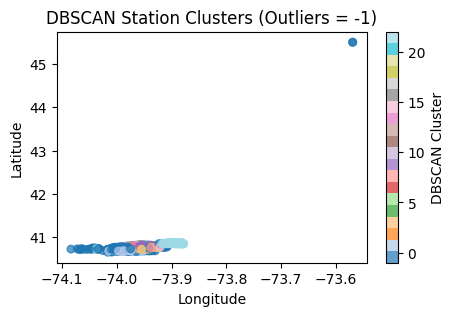

Stations in clusters: 836
Stations labeled as noise: 121
23 clusters created
   station_uid   latitude  longitude  cluster
0            0  40.767272 -73.993929        0
1            1  40.719116 -74.006667        0
2            2  40.711174 -74.000165        0
3            3  40.683826 -73.976323        1
4            4  40.696089 -73.978034       -1


In [ ]:
from sklearn.cluster import DBSCAN

def cluster_stations_dbscan(stations: pd.DataFrame, eps=0.0037, min_samples=4, mark_noise=False) -> pd.DataFrame:
    # Prepare coordinates for DBSCAN
    coords = stations[['latitude', 'longitude']].values

    # DBSCAN parameters: eps is in degrees, min_samples is minimum cluster size
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)  # eps ~1km, adjust as needed
    stations['cluster'] = dbscan.fit_predict(coords)


    # Summary
    print("DBSCAN cluster labels (including -1 for outliers):")
    print(stations['cluster'].value_counts().sort_index())
    plt.figure(figsize=(5, 3))
    scatter = plt.scatter(
        stations['longitude'], stations['latitude'],
        c=stations['cluster'], cmap='tab20', s=30, alpha=0.7
    )
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('DBSCAN Station Clusters (Outliers = -1)')
    plt.colorbar(scatter, label='DBSCAN Cluster')
    plt.show()

    clustered_stations = stations[stations['cluster'] != -1].reset_index(drop=True)
    print(f"Stations in clusters: {len(clustered_stations)}")
    print(f"Stations labeled as noise: {(stations['cluster'] == -1).sum()}")
    print(f"{stations['cluster'].max() + 1} clusters created")

    if not mark_noise:
        # Optionally mark noise points (cluster = -1) as NaN
        stations = stations[stations['cluster'] != -1].reset_index(drop=True)
        
    print(stations.head())
    return stations

stations = cluster_stations_dbscan(stations, eps=0.0037, min_samples=4)

Number of stations in each cluster:
cluster
0     27
1      2
2     55
3     71
4     46
5     65
6     66
7     42
8     61
9     33
10    89
11    28
12    35
13    60
14    51
15    52
16    56
17    41
18    46
19    31
Name: count, dtype: int64

Cluster centers:
     latitude  longitude
0   40.743909 -73.954078
1   45.506314 -73.569185
2   40.852255 -73.886891
3   40.725759 -73.984296
4   40.674037 -73.983608
5   40.800250 -73.947260
6   40.740827 -73.998936
7   40.791108 -73.971705
8   40.693958 -73.983545
9   40.689953 -73.945000
10  40.758971 -73.982386
11  40.720985 -74.046721
12  40.758273 -73.934657
13  40.713597 -74.006032
14  40.854706 -73.905529
15  40.773639 -73.956583
16  40.715500 -73.952941
17  40.676539 -74.005190
18  40.676719 -73.961720
19  40.769338 -73.919788


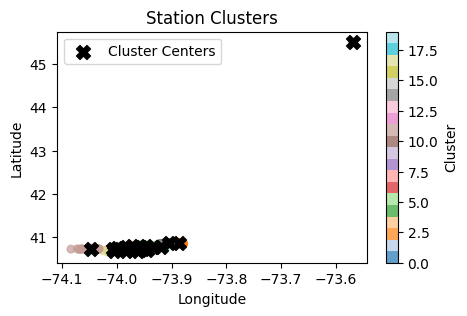

Clusters dropped due to low station count (<4): [1]
Clusters kept: 19
   station_uid   latitude  longitude  cluster
0            0  40.767272 -73.993929       10
1            1  40.719116 -74.006667       13
2            2  40.711174 -74.000165       13
3            3  40.683826 -73.976323        4
4            4  40.696089 -73.978034        8


In [ ]:
from sklearn.cluster import KMeans

def cluster_stations_kmeans(stations: pd.DataFrame, K:int, min_samples:int = 0, mark_noise=False) -> pd.DataFrame:
    # Prepare the coordinates for clustering
    X = stations[['latitude', 'longitude']].values

    # Initialize and fit KMeans
    kmeans = KMeans(n_clusters=K, random_state=42)
    stations['cluster'] = kmeans.fit_predict(X)


    # Print summary of clusters
    print("Number of stations in each cluster:")
    print(stations['cluster'].value_counts().sort_index())
    # Add cluster centers to the summary
    cluster_centers = pd.DataFrame(
        kmeans.cluster_centers_, 
        columns=['latitude', 'longitude']
    )
    print("\nCluster centers:")
    print(cluster_centers)

    plt.figure(figsize=(5, 3))
    scatter = plt.scatter(
        stations['longitude'], stations['latitude'], 
        c=stations['cluster'], cmap='tab20', s=30, alpha=0.7
    )
    plt.scatter(
        cluster_centers['longitude'], cluster_centers['latitude'], 
        c='black', marker='X', s=100, label='Cluster Centers'
    )
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Station Clusters')
    plt.legend()
    plt.colorbar(scatter, label='Cluster')
    plt.show()

    if min_samples > 0:
            
        # add cluster sizes for kmeans clusters
        stations['cluster_n'] = stations.groupby('cluster')['cluster'].transform('count')
        low_count_clusters = stations.loc[stations['cluster_n'] < min_samples, 'cluster'].unique()

        # Mark these clusters as dropped (-1)
        stations.loc[stations['cluster'].isin(low_count_clusters), 'cluster'] = pd.NA if mark_noise else -1

        if mark_noise == False:
            # Drop stations in low-count clusters
            stations = stations[stations['cluster'] != -1].reset_index(drop=True)

        print(f"Clusters dropped due to low station count (<{min_samples}): {low_count_clusters}")
        print(f"Clusters kept: {stations['cluster'].nunique() - (1 if -1 in stations['cluster'].unique() else 0)}")

        stations.drop('cluster_n', axis=1, inplace=True, errors='ignore')

    print(stations.head())

    return stations

stations = cluster_stations_kmeans(stations, K=20, min_samples=4)

In [7]:
import folium

def stations_clusters_on_map(stations: pd.DataFrame):
    # Create a map centered at the mean coordinates of all stations
    center_lat = stations['latitude'].mean()
    center_lon = stations['longitude'].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

    # Add markers for each station, colored by cluster
    colors = ['#%06x' % np.random.randint(0, 0xFFFFFF) for _ in range(stations["cluster"].nunique())]

    for _, row in stations.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            color=colors[int(row["cluster"])] if row["cluster"] != -1 else 'gray',
            fill=True,
            popup=f"Cluster {row["cluster"]}"
        ).add_to(m)

    """# Add markers for cluster centers
    for i, center in cluster_centers.iterrows():
        folium.Marker(
            location=[center['latitude'], center['longitude']],
            icon=folium.Icon(color='black', icon='info-sign'),
            popup=f'Cluster Center {i}'
        ).add_to(m)"""
    display(m)

stations_clusters_on_map(stations)

In [ ]:
def map_trips_to_station_clusters(df: pd.DataFrame, stations: pd.DataFrame, ) -> pd.DataFrame:
    # create a mapping from coordinate tuple -> station_uid and add uid columns to trips df
    coord_to_cluster = { (row.latitude, row.longitude): row.cluster for row in stations.itertuples() }

    # vectorized creation of coordinate tuples and mapping
    df['start_coord'] = list(zip(df['start_station_latitude'], df['start_station_longitude']))
    df['end_coord'] = list(zip(df['end_station_latitude'], df['end_station_longitude']))

    df['start_cluster'] = df['start_coord'].map(coord_to_cluster)
    df['end_cluster'] = df['end_coord'].map(coord_to_cluster)

    # cleanup temporary columns if you don't want to keep them
    df.drop(columns=['start_station_id', 'end_station_id', 'start_coord', 'end_coord', 'start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude'], inplace=True)

    print(df.head())
    return df   

#map_trips_to_station_clusters(df, stations, "cluster_dbscan")
df = map_trips_to_station_clusters(df, stations)

create heatmap based on the station where is the highest demand in the city for pick up and where most people drops it down. 
Create heatmap for a week based on the all demant by time. On vertical the time of the day, on horizontal the days. 

Hourly mean pickups
weekday mean pickups
rolling mean (168h) pickups

### DATE TIME

In [11]:
df.head()

,tripduration,starttime,stoptime,bikeid,usertype,birth_year,gender,start_cluster,end_cluster
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,31956,Subscriber,1992,1,10,10
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,32536,Subscriber,1969,1,10,6
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,16069,Subscriber,1956,1,10,6
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,31781,Subscriber,1974,1,10,10
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,30319,Subscriber,1992,1,10,10


In [12]:
def validate_tripduration(df: pd.DataFrame) -> None:
    # validate tripduration vs stoptime - starttime
    # convert to datetime if needed
    if df['starttime'].dtype == object:
        df['starttime'] = pd.to_datetime(df['starttime'])
    if df['stoptime'].dtype == object:
        df['stoptime'] = pd.to_datetime(df['stoptime'])

    # compute durations (seconds)
    #df['computed_duration'] = (df['stoptime'] - df['starttime']).dt.total_seconds()
    computed_duration = (df['stoptime'] - df['starttime']).dt.total_seconds()


    # summary comparisons
    n_total = len(df)
    n_exact = (df['tripduration'] == computed_duration).sum()
    n_rounded = (df['tripduration'] == computed_duration.round()).sum()
    n_within1 = (df['tripduration'] - computed_duration).abs().le(1).sum()
    n_diff_gt1 = (df['tripduration'] - computed_duration).abs().gt(1).sum()


    print("Trip Duration Validation Summary:")
    print(f"total rows: {n_total}")
    print(f"exact float match: {n_exact} ({n_exact/n_total:.2%})")
    print(f"match after rounding computed duration: {n_rounded} ({n_rounded/n_total:.2%})")
    print(f"within 1s tolerance: {n_within1} ({n_within1/n_total:.2%})")
    print(f"differences > 1s: {n_diff_gt1} ({n_diff_gt1/n_total:.2%})")

    # diagnostics for differences > 1s
    diff = computed_duration - df['tripduration']
    print("\nDifference (computed - reported) statistics (seconds):")
    print(diff.describe())


    # Find trips where starttime is later than stoptime
    invalid_trips = df[df['starttime'] > df['stoptime']]

    print(f"\nNumber of invalid trips (start > stop): {len(invalid_trips)}")
    if len(invalid_trips) > 0:
        print("\nSample of invalid trips:")
        display(invalid_trips[['starttime', 'stoptime', 'tripduration']].head())
    else:
        print("No invalid trips found.")

validate_tripduration(df)

Trip Duration Validation Summary:
total rows: 17548339
exact float match: 17545 (0.10%)
match after rounding computed duration: 8784724 (50.06%)
within 1s tolerance: 17548188 (100.00%)
differences > 1s: 151 (0.00%)

Difference (computed - reported) statistics (seconds):
count    1.754834e+07
mean     5.016629e-01
std      1.056417e+01
min     -3.599989e+03
25%      2.490000e-01
50%      4.990000e-01
75%      7.490000e-01
max      3.600992e+03
dtype: float64

Number of invalid trips (start > stop): 0
No invalid trips found.


In [14]:
def create_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create time-based features from starttime and stoptime columns."""
    print("Creating time-based features...")


    # Create hour features from starttime and stoptime
    # Create hour features rounded down to the hour (date + hour:00)
    df['start_datetime_hour'] = df['starttime'].dt.floor('H')
    df['stop_datetime_hour'] = df['stoptime'].dt.floor('H')

    df.drop(["starttime", "stoptime"], axis=1, inplace=True)

    # Add day of week (0=Monday, 6=Sunday)
    #df['start_weekday'] = df['start_datetime_hour'].dt.dayofweek
    #df['stop_weekday'] = df['stop_datetime_hour'].dt.dayofweek

    print("Sample of new features:")
    print(df.head())
    return df

create_time_features(df)

Creating time-based features...


KeyError: 'starttime'

In [20]:
df.head(), df.shape, df.end_cluster.min(), df.end_cluster.max()

(   tripduration  bikeid    usertype  birth_year  gender  start_cluster  \
 0           970   31956  Subscriber        1992       1             10   
 1           723   32536  Subscriber        1969       1             10   
 2           496   16069  Subscriber        1956       1             10   
 3           306   31781  Subscriber        1974       1             10   
 4           306   30319  Subscriber        1992       1             10   
 
    end_cluster start_datetime_hour  stop_datetime_hour  
 0           10 2018-01-01 13:00:00 2018-01-01 14:00:00  
 1            6 2018-01-01 15:00:00 2018-01-01 15:00:00  
 2            6 2018-01-01 15:00:00 2018-01-01 15:00:00  
 3           10 2018-01-01 15:00:00 2018-01-01 15:00:00  
 4           10 2018-01-01 18:00:00 2018-01-01 18:00:00  ,
 (17548339, 9),
 -1,
 19)

In [ ]:
# count trips that cross midnight (start and stop on different calendar dates)
cross_midnight_mask = df['start_datetime_hour'].dt.date != df['stop_datetime_hour'].dt.date
n_cross_midnight = cross_midnight_mask.sum()
n_total = len(df)

print(f"Trips crossing midnight: {n_cross_midnight} / {n_total} ({n_cross_midnight / n_total:.4%})")

# show a few examples
display(df.loc[cross_midnight_mask, ['tripduration','start_datetime_hour','stop_datetime_hour']].head(10))

In [28]:
def convert_pickup_dropoff_to_demand(df: pd.DataFrame) -> pd.DataFrame:
    # pickups per hour/cluster
    pick = (
        df[['start_datetime_hour', 'start_cluster']]
        .groupby(['start_datetime_hour', 'start_cluster'])
        .size()
        .reset_index(name='pickups')
        .rename(columns={'start_datetime_hour': 'datetime', 'start_cluster': 'cluster'})
    )

    # dropoffs per hour/cluster
    drop = (
        df[['stop_datetime_hour', 'end_cluster']]
        .groupby(['stop_datetime_hour', 'end_cluster'])
        .size()
        .reset_index(name='dropoffs')
        .rename(columns={'stop_datetime_hour': 'datetime', 'end_cluster': 'cluster'})
    )

    # merge pickups and dropoffs, fill missing with 0
    agg = pd.merge(pick, drop, on=['datetime', 'cluster'], how='outer').fillna(0)
    agg['pickups'] = agg['pickups'].astype(int)
    agg['dropoffs'] = agg['dropoffs'].astype(int)
    agg['demand'] = agg['pickups'] + agg['dropoffs']


    # result: `agg` with datetime index and one row per (datetime, cluster)
    return agg

agg = convert_pickup_dropoff_to_demand(df.copy())
agg.head()

,datetime,cluster,pickups,dropoffs,demand
0,2018-01-01,0,2,0,2
1,2018-01-01,3,19,23,42
2,2018-01-01,4,3,2,5
3,2018-01-01,5,3,3,6
4,2018-01-01,6,22,18,40


In [ ]:
# set datetime as index
agg.set_index('datetime', inplace=True)
agg.sort_index(inplace=True)


KeyError: "None of ['datetime'] are in the columns"

In [45]:
agg.head()


,cluster,pickups,dropoffs,demand,weekday,hour
datetime,,,,,,
2018-01-01,0,2,0,2,0,0
2018-01-01,3,19,23,42,0,0
2018-01-01,4,3,2,5,0,0
2018-01-01,5,3,3,6,0,0
2018-01-01,6,22,18,40,0,0


In [ ]:
# Export the aggregated data to CSV
agg.to_csv('aggregated_demand_data.csv')

# You can also save it as a pickle file which preserves the data types
agg.to_pickle('aggregated_demand_data.pkl')

print("Data exported successfully!")

Data exported successfully!


In [ ]:
#agg2 = pd.read_csv('aggregated_demand_data.csv', index_col=0, parse_dates=True)

#agg3 = pd.read_pickle('aggregated_demand_data.pkl')

In [ ]:
"""from matplotlib import colors as mcolors
from folium.plugins import HeatMap

# SUMMED DEMAND HEATMAP (cell 19)

# sum total demand per cluster across the dataset
cluster_total = agg.groupby('cluster')['demand'].sum().reset_index()

# merge with cluster centers (cluster_centers index corresponds to cluster id)
cluster_centers_idx = cluster_centers.reset_index().rename(columns={'index': 'cluster'})
cluster_total = cluster_total.merge(cluster_centers_idx, on='cluster', how='left').dropna(subset=['latitude','longitude'])

# normalize sizes and colors
max_d = cluster_total['demand'].max()
cluster_total['radius'] = (cluster_total['demand'] / max_d) * 40 + 5  # radius in pixels

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=cluster_total['demand'].min(), vmax=max_d)

# create folium map centered on existing center
m_demand = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# add circle markers sized & colored by total demand
for _, r in cluster_total.iterrows():
    color = mcolors.to_hex(cmap(norm(r['demand'])))
    folium.CircleMarker(
        location=[r['latitude'], r['longitude']],
        radius=float(r['radius']),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Cluster {int(r['cluster'])} — Demand: {int(r['demand'])}"
    ).add_to(m_demand)

# add HeatMap layer (weights proportional to demand)
heat_data = [[r['latitude'], r['longitude'], r['demand']/max_d] for _, r in cluster_total.iterrows()]
HeatMap(heat_data, radius=25, max_zoom=13).add_to(m_demand)

m_demand"""

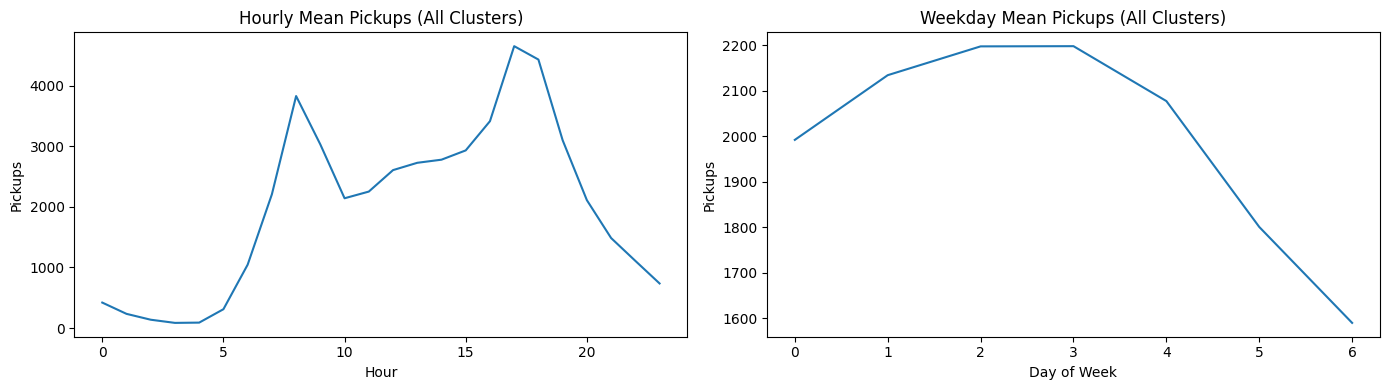

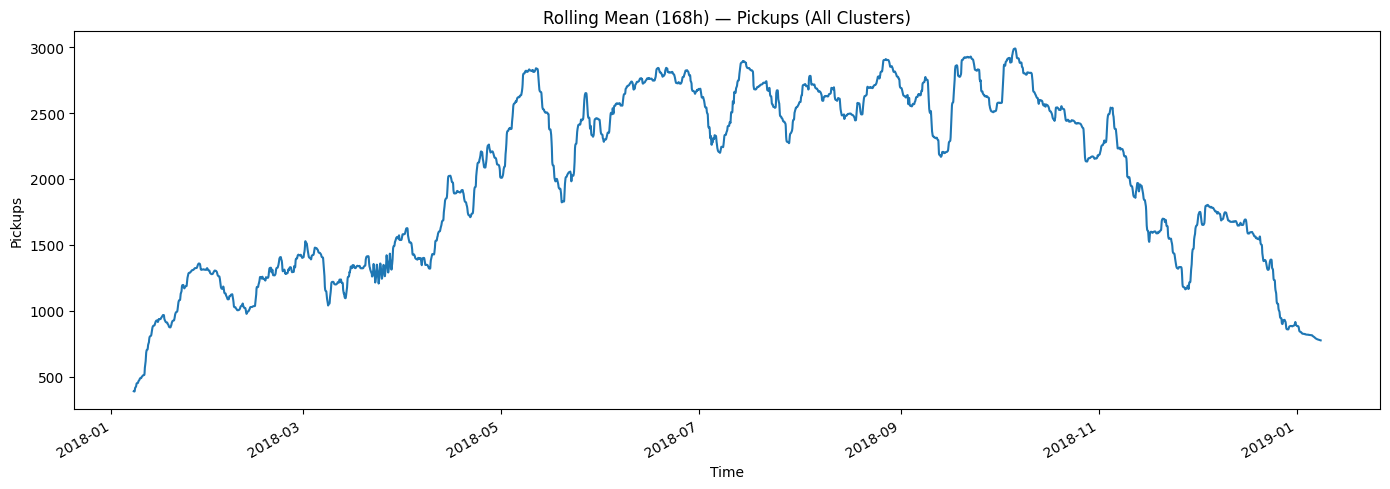

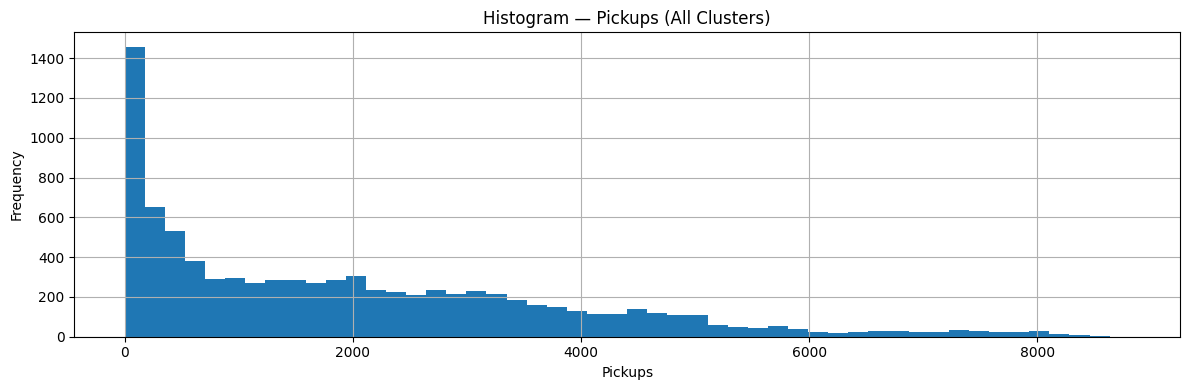

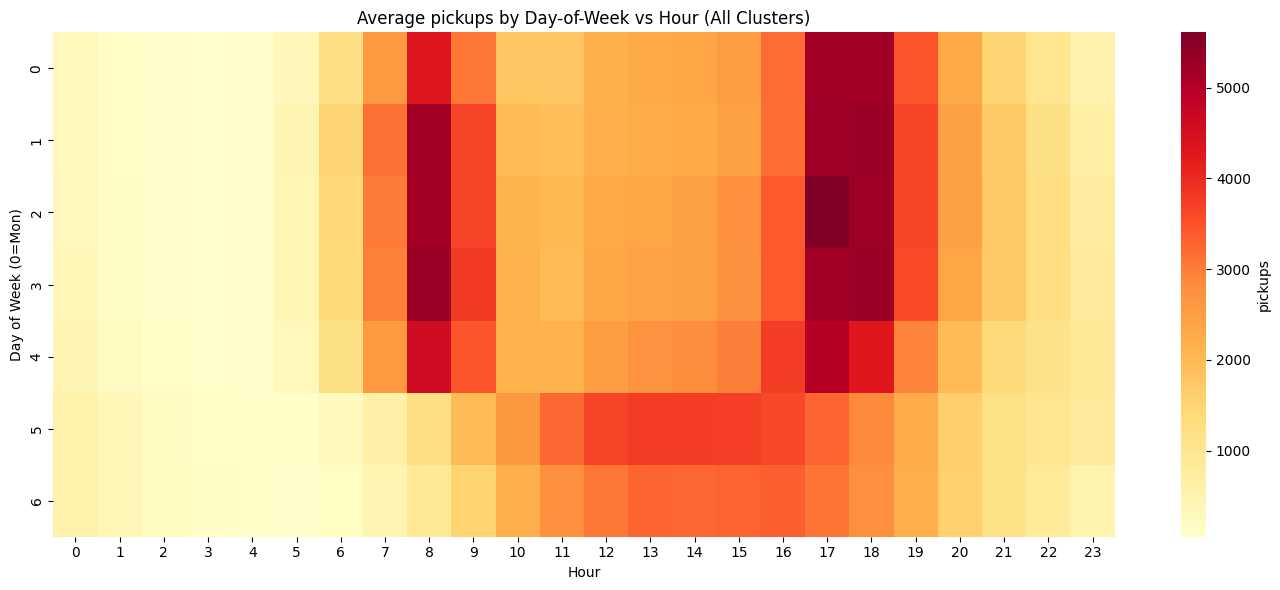

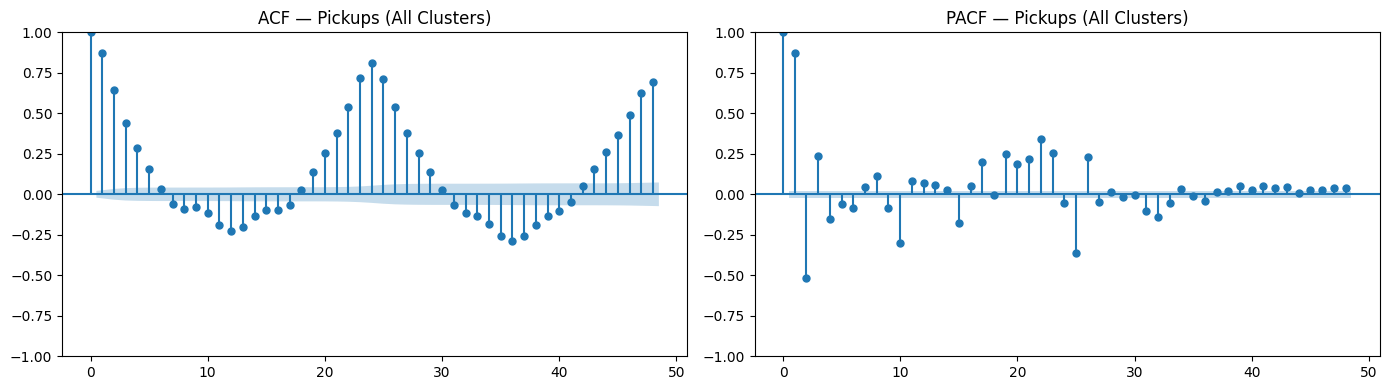

In [51]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Aggregate demand across all clusters
ts_total = agg.groupby(agg.index)[['pickups', 'dropoffs']].sum()

def calendar_heatmap(ts, value_col="pickups", title_suffix=""):
    d = ts.copy()
    d["hour"] = d.index.hour
    d["dow"]  = d.index.dayofweek
    pivot = d.pivot_table(index="dow", columns="hour", values=value_col, aggfunc="mean")
    plt.figure(figsize=(14, 6))
    sns.heatmap(pivot, cmap='YlOrRd', cbar_kws={'label': value_col})
    plt.title(f"Average {value_col} by Day-of-Week vs Hour {title_suffix}")
    plt.xlabel("Hour"); plt.ylabel("Day of Week (0=Mon)")
    plt.tight_layout()

def seasonal_lineplots(ts, title_suffix=""):
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    ts.groupby(ts.index.hour)["pickups"].mean().plot(ax=axes[0])
    axes[0].set_title(f"Hourly Mean Pickups {title_suffix}"); axes[0].set_xlabel("Hour"); axes[0].set_ylabel("Pickups")

    ts.groupby(ts.index.dayofweek)["pickups"].mean().plot(ax=axes[1])
    axes[1].set_title(f"Weekday Mean Pickups {title_suffix}"); axes[1].set_xlabel("Day of Week"); axes[1].set_ylabel("Pickups")
    plt.tight_layout()

def rolling_stats(ts, window=168, title_suffix=""):
    plt.figure(figsize=(14, 5))
    ts["pickups"].rolling(window).mean().plot()
    plt.title(f"Rolling Mean ({window}h) — Pickups {title_suffix}"); plt.xlabel("Time"); plt.ylabel("Pickups")
    plt.tight_layout()

def distribution_plots(ts, title_suffix=""):
    plt.figure(figsize=(12, 4))
    ts["pickups"].hist(bins=50)
    plt.title(f"Histogram — Pickups {title_suffix}"); plt.xlabel("Pickups"); plt.ylabel("Frequency")
    plt.tight_layout()

def correlation_plots(ts, title_suffix=""):
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    plot_acf(ts["pickups"], lags=48, ax=axes[0]); axes[0].set_title(f"ACF — Pickups {title_suffix}")
    plot_pacf(ts["pickups"], lags=48, ax=axes[1]); axes[1].set_title(f"PACF — Pickups {title_suffix}")
    plt.tight_layout()

seasonal_lineplots(ts_total, "(All Clusters)")
rolling_stats(ts_total, title_suffix="(All Clusters)")
distribution_plots(ts_total, title_suffix="(All Clusters)")
calendar_heatmap(ts_total, "pickups", "(All Clusters)")
correlation_plots(ts_total, title_suffix="(All Clusters)")


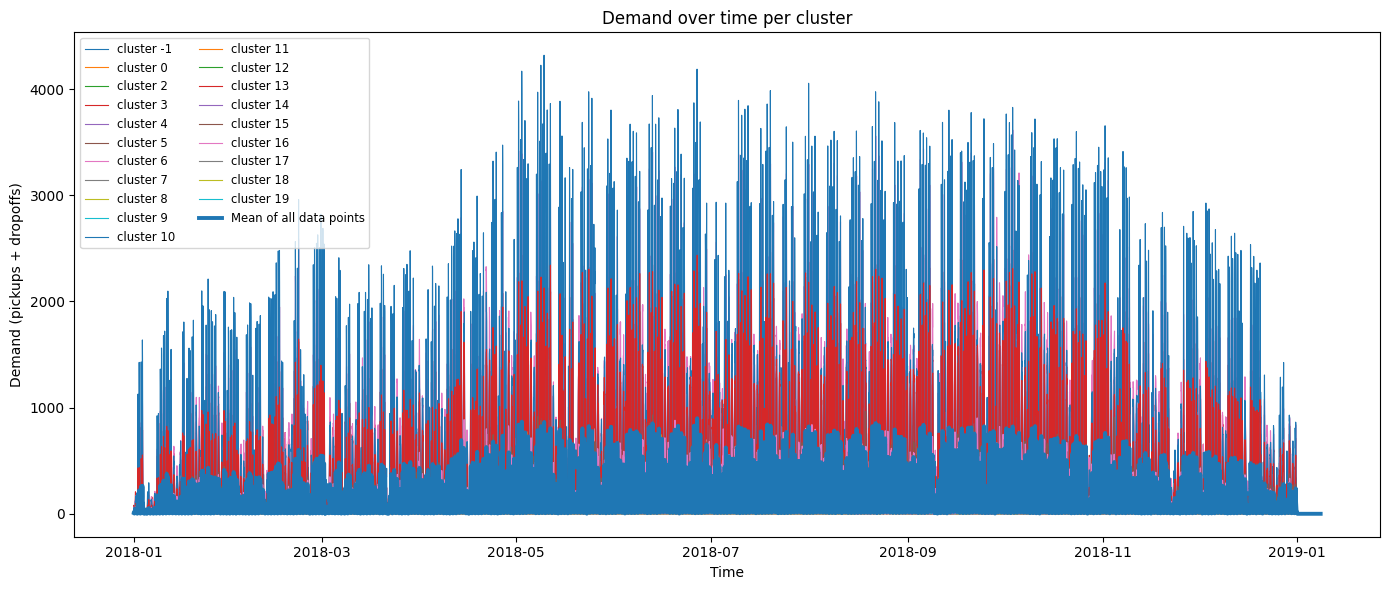

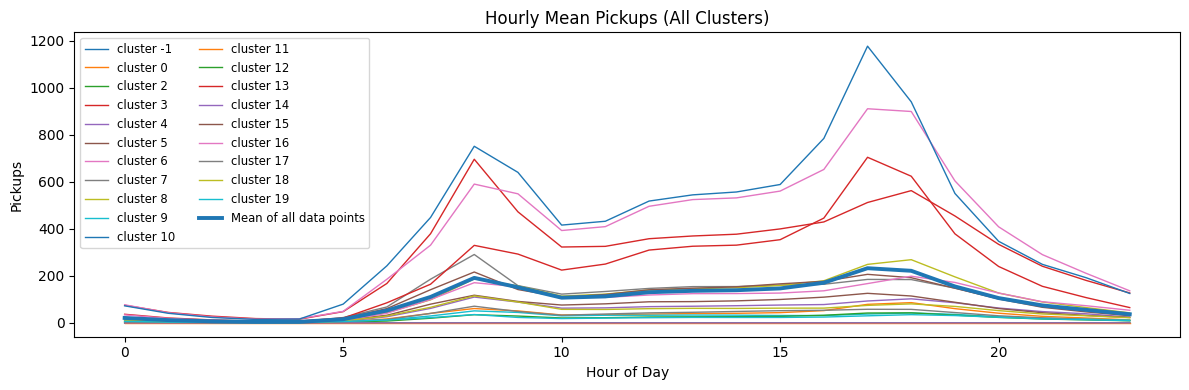

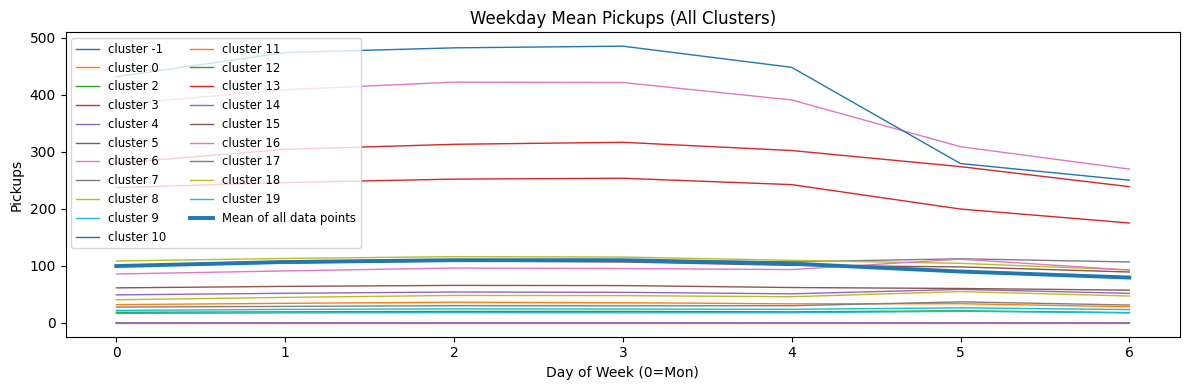

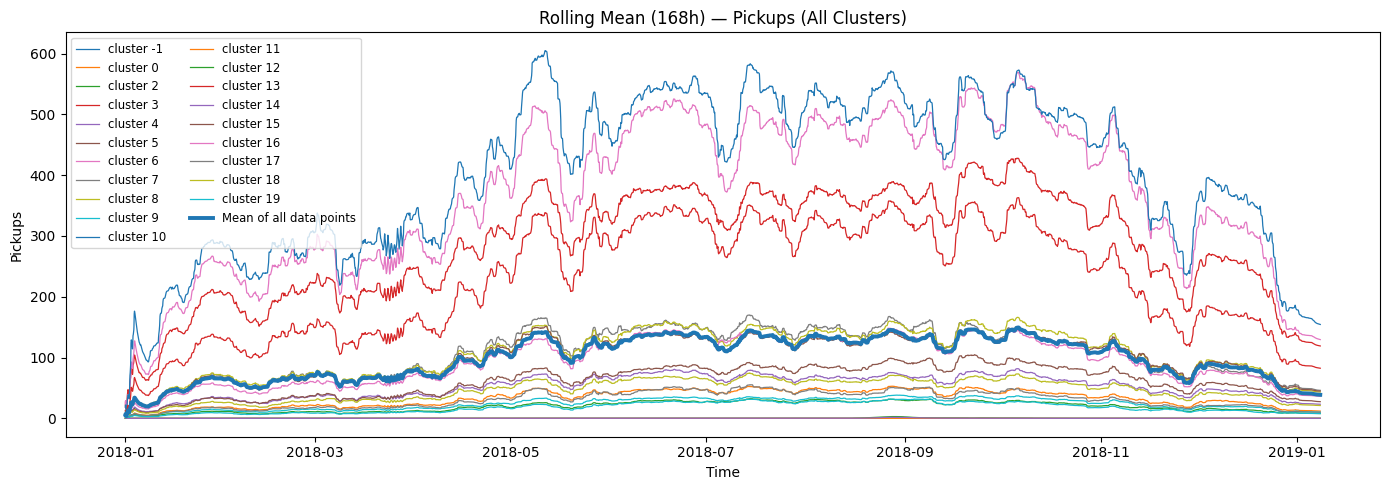

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- helpers ---------------------------------------------------------------

def _wide(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """Make wide time x cluster matrix for a given series (e.g., 'demand' or 'pickups')."""
    w = (
        df.groupby([df.index, "cluster"])[col]
          .sum()
          .unstack("cluster", fill_value=0)
          .sort_index()
    )
    try:
        w = w.reindex(sorted(w.columns), axis=1)  # numeric sort if possible
    except Exception:
        pass
    return w

def _plot_all_clusters(wide_df: pd.DataFrame, label_prefix: str, lw=1):
    for c in wide_df.columns:
        plt.plot(wide_df.index, wide_df[c], linewidth=lw, label=f"{label_prefix} {int(c)}")

def _plot_overall_mean(wide_df: pd.DataFrame, label="Mean of all clusters", lw=2.5):
    overall = wide_df.mean(axis=1)
    plt.plot(overall.index, overall.values, linewidth=lw, label=label)

def _plot_highlights(wide_df: pd.DataFrame, highlight_clusters=None, label_prefix="Center of Cluster", lw=2.5):
    if highlight_clusters:
        for cid in highlight_clusters:
            if cid in wide_df.columns:
                plt.plot(wide_df.index, wide_df[cid], linewidth=lw, label=f"{label_prefix} {int(cid)}")

# --- 1) Demand over time per cluster --------------------------------------

def plot_demand_over_time_per_cluster(agg, highlight_clusters=None):
    agg = _ensure_demand(agg)
    w = _wide(agg, "demand")

    plt.figure(figsize=(14, 6))
    _plot_all_clusters(w, "cluster", lw=0.8)     # all clusters thin
    _plot_overall_mean(w, "Mean of all data points", lw=2.8)
    _plot_highlights(w, highlight_clusters, "Center point of Cluster", lw=3.2)

    plt.xlabel("Time")
    plt.ylabel("Demand (pickups + dropoffs)")
    plt.title("Demand over time per cluster")
    plt.legend(loc="upper left", ncol=2, fontsize="small")
    plt.tight_layout()
    plt.show()

# Example:
# plot_demand_over_time_per_cluster(agg, highlight_clusters=[1,2])

# --- 2) Hourly mean pickups (all clusters + overall mean + highlights) ----

def plot_hourly_mean_pickups(agg, highlight_clusters=None, title_suffix="(All Clusters)"):
    w = _wide(agg, "pickups")
    hourly = w.groupby(w.index.hour).mean()          # per-hour mean per cluster (columns)

    plt.figure(figsize=(12, 4))
    _plot_all_clusters(hourly, "cluster", lw=1.0)
    _plot_overall_mean(hourly, "Mean of all data points", lw=2.8)
    _plot_highlights(hourly, highlight_clusters, "Center point of Cluster", lw=3.2)

    plt.title(f"Hourly Mean Pickups {title_suffix}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Pickups")
    plt.tight_layout()
    plt.legend(loc="upper left", ncol=2, fontsize="small")
    plt.show()

# --- 3) Weekday mean pickups (0=Mon … 6=Sun) ------------------------------

def plot_weekday_mean_pickups(agg, highlight_clusters=None, title_suffix="(All Clusters)"):
    w = _wide(agg, "pickups")
    wd = w.groupby(w.index.dayofweek).mean()

    plt.figure(figsize=(12, 4))
    _plot_all_clusters(wd, "cluster", lw=1.0)
    _plot_overall_mean(wd, "Mean of all data points", lw=2.8)
    _plot_highlights(wd, highlight_clusters, "Center point of Cluster", lw=3.2)

    plt.title(f"Weekday Mean Pickups {title_suffix}")
    plt.xlabel("Day of Week (0=Mon)")
    plt.ylabel("Pickups")
    plt.legend(loc="upper left", ncol=2, fontsize="small")
    plt.tight_layout()
    plt.show()

# --- 4) Rolling mean pickups (168h weekly window) -------------------------

def plot_rolling_pickups(agg, window=168, highlight_clusters=None, title_suffix="(All Clusters)"):
    w = _wide(agg, "pickups")
    w_roll = w.rolling(window, min_periods=1).mean()

    plt.figure(figsize=(14, 5))
    _plot_all_clusters(w_roll, "cluster", lw=0.9)
    _plot_overall_mean(w_roll, "Mean of all data points", lw=2.8)
    _plot_highlights(w_roll, highlight_clusters, "Center point of Cluster", lw=3.2)

    plt.title(f"Rolling Mean ({window}h) — Pickups {title_suffix}")
    plt.xlabel("Time")
    plt.ylabel("Pickups")
    plt.legend(loc="upper left", ncol=2, fontsize="small")
    plt.tight_layout()
    plt.show()

# --- Run them (example) ---------------------------------------------------
plot_demand_over_time_per_cluster(agg, highlight_clusters=None)
plot_hourly_mean_pickups(agg, highlight_clusters=None)
plot_weekday_mean_pickups(agg, highlight_clusters=None)
plot_rolling_pickups(agg, window=168, highlight_clusters=None)


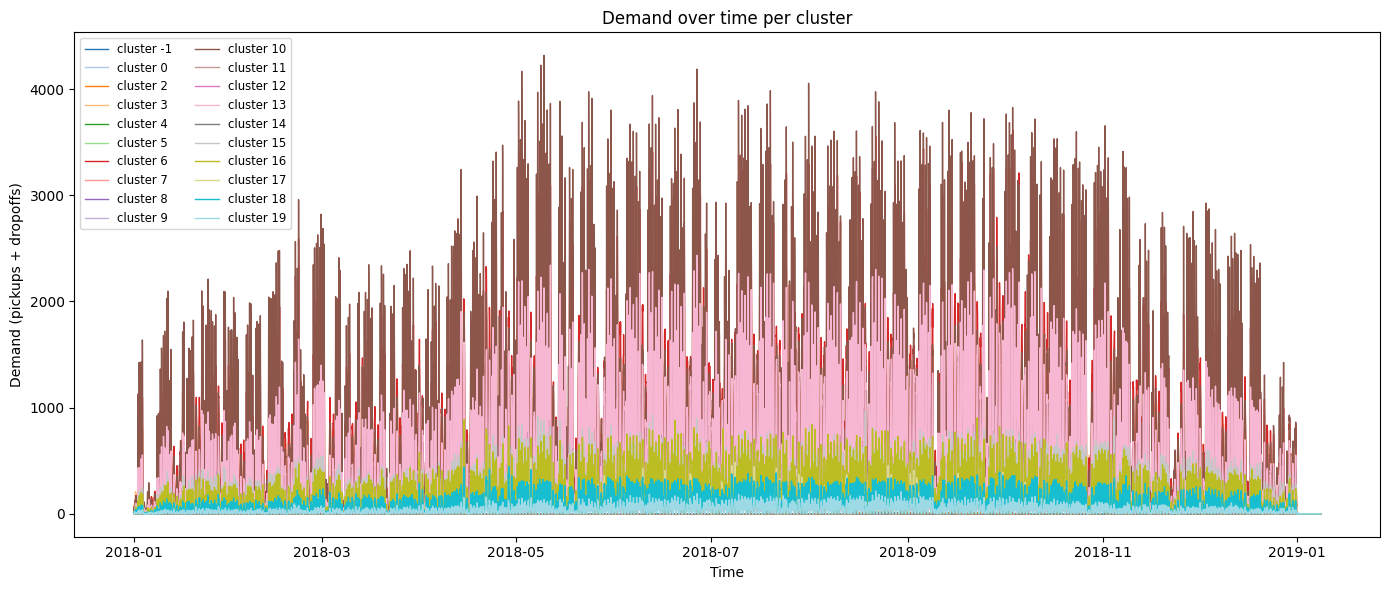

cluster,-1,0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
datetime,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.0,2.0,0.0,42.0,5.0,6.0,40.0,12.0,6.0,4.0,27.0,0.0,0.0,18.0,0.0,18.0,16.0,0.0,7.0,4.0
2018-01-01 01:00:00,0.0,5.0,0.0,81.0,18.0,16.0,64.0,15.0,11.0,6.0,58.0,0.0,0.0,17.0,0.0,19.0,16.0,5.0,8.0,5.0
2018-01-01 02:00:00,0.0,6.0,0.0,34.0,3.0,4.0,33.0,12.0,8.0,5.0,31.0,0.0,5.0,17.0,0.0,14.0,14.0,1.0,15.0,5.0
2018-01-01 03:00:00,0.0,2.0,0.0,30.0,0.0,4.0,29.0,5.0,6.0,11.0,20.0,0.0,3.0,8.0,0.0,4.0,11.0,0.0,5.0,6.0
2018-01-01 04:00:00,0.0,0.0,0.0,12.0,6.0,4.0,16.0,2.0,7.0,1.0,12.0,0.0,3.0,1.0,0.0,5.0,3.0,2.0,3.0,0.0


In [67]:
# pivot to wide format: index = time, columns = cluster, values = demand
df_wide = agg.reset_index().pivot(index='datetime', columns='cluster', values='demand').fillna(0)
df_wide = df_wide.reindex(sorted(df_wide.columns), axis=1)

plt.figure(figsize=(14, 6))
cmap = plt.cm.tab20
colors = [cmap(i % 20) for i in range(len(df_wide.columns))]

for i, col in enumerate(df_wide.columns):
    label = f"cluster {int(col)}" if not pd.isna(col) else "cluster NaN"
    plt.plot(df_wide.index, df_wide[col], color=colors[i], linewidth=1, label=label)

plt.xlabel('Time')
plt.ylabel('Demand (pickups + dropoffs)')
plt.title('Demand over time per cluster')
plt.legend(loc='upper left', ncol=2, fontsize='small')
plt.tight_layout()
plt.show()

df_wide.head()



In [ ]:
#NOT CORRECT, MUST BE FIXED


# define cutoff between trainset and testset
trainset_end = pd.to_datetime('2015-05-31 01:00:00')
validationset_start = pd.to_datetime('2015-06-01 01:00:00')
validationset_end = pd.to_datetime('2015-07-31 01:00:00')
testset_start = pd.to_datetime('2015-08-01 01:00:00')

# train/val/test split
X_train = labeled_features.loc[labeled_features['datetime'] < trainset_end, features_to_use]
y_train = labeled_features.loc[labeled_features['datetime'] < trainset_end, target_variables]
X_val = labeled_features.loc[((labeled_features['datetime'] > validationset_start) & (labeled_features['datetime'] < validationset_end)), features_to_use]
y_val = labeled_features.loc[((labeled_features['datetime'] > validationset_start) & (labeled_features['datetime'] < validationset_end)), target_variables]
X_test = labeled_features.loc[labeled_features['datetime'] > testset_start, features_to_use]
y_test = labeled_features.loc[labeled_features['datetime'] > testset_start, target_variables]

print("Num train examples:", len(y_train))
print("Num validation examples:", len(y_val))
print("Num test examples:", len(y_test))

NameError: name 'pd' is not defined

Selected clusters for prediction: [18, 9, 16, 3, 10]
Forecasting cluster 18 with XGB ...


C:\Users\Tomi\AppData\Local\Temp\ipykernel_16660\600843417.py:45: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.date_range(df.index.min().floor("H"), df.index.max().ceil("H") - pd.Timedelta(hours=0), freq="H")


Forecasting cluster 9 with XGB ...


C:\Users\Tomi\AppData\Local\Temp\ipykernel_16660\600843417.py:45: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.date_range(df.index.min().floor("H"), df.index.max().ceil("H") - pd.Timedelta(hours=0), freq="H")


Forecasting cluster 16 with XGB ...


C:\Users\Tomi\AppData\Local\Temp\ipykernel_16660\600843417.py:45: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.date_range(df.index.min().floor("H"), df.index.max().ceil("H") - pd.Timedelta(hours=0), freq="H")


Forecasting cluster 3 with XGB ...


C:\Users\Tomi\AppData\Local\Temp\ipykernel_16660\600843417.py:45: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.date_range(df.index.min().floor("H"), df.index.max().ceil("H") - pd.Timedelta(hours=0), freq="H")


Forecasting cluster 10 with XGB ...


C:\Users\Tomi\AppData\Local\Temp\ipykernel_16660\600843417.py:45: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.date_range(df.index.min().floor("H"), df.index.max().ceil("H") - pd.Timedelta(hours=0), freq="H")


,cluster,target,MAE,RMSE,N
1,3,dropoffs,119.963181,167.827505,1464
3,9,dropoffs,8.412779,12.056230,1464
5,10,dropoffs,184.417882,303.319447,1464
7,16,dropoffs,35.236296,51.981688,1464
9,18,dropoffs,17.477141,25.305041,1464
0,3,pickups,116.963373,187.639554,1464
2,9,pickups,9.070360,14.170615,1464
4,10,pickups,178.730217,268.725928,1464
6,16,pickups,35.327617,54.778094,1464
8,18,pickups,19.850681,32.668571,1464


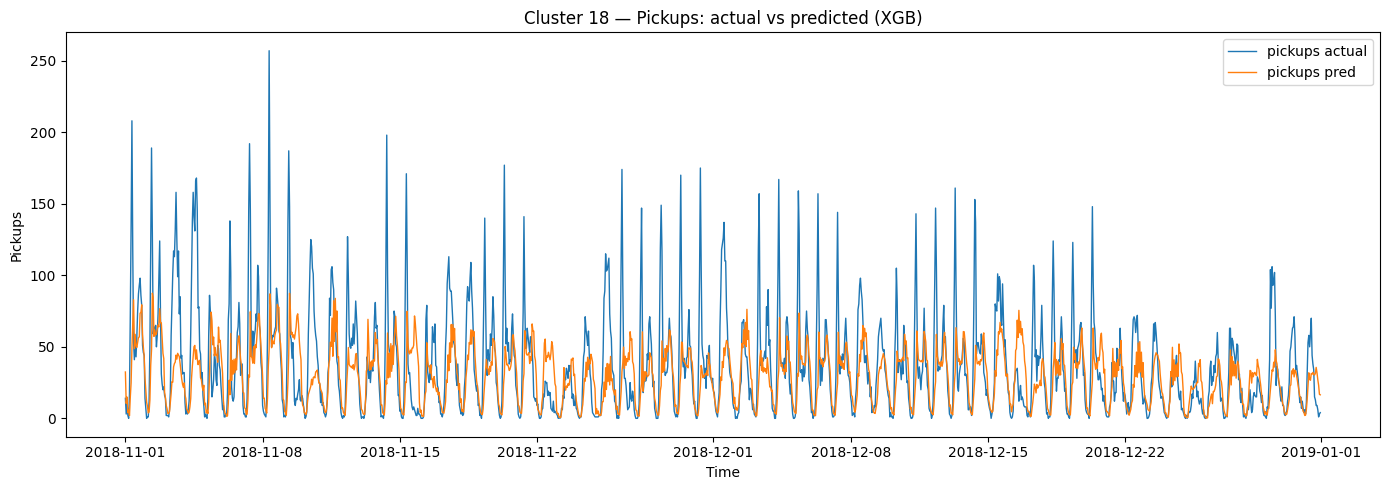

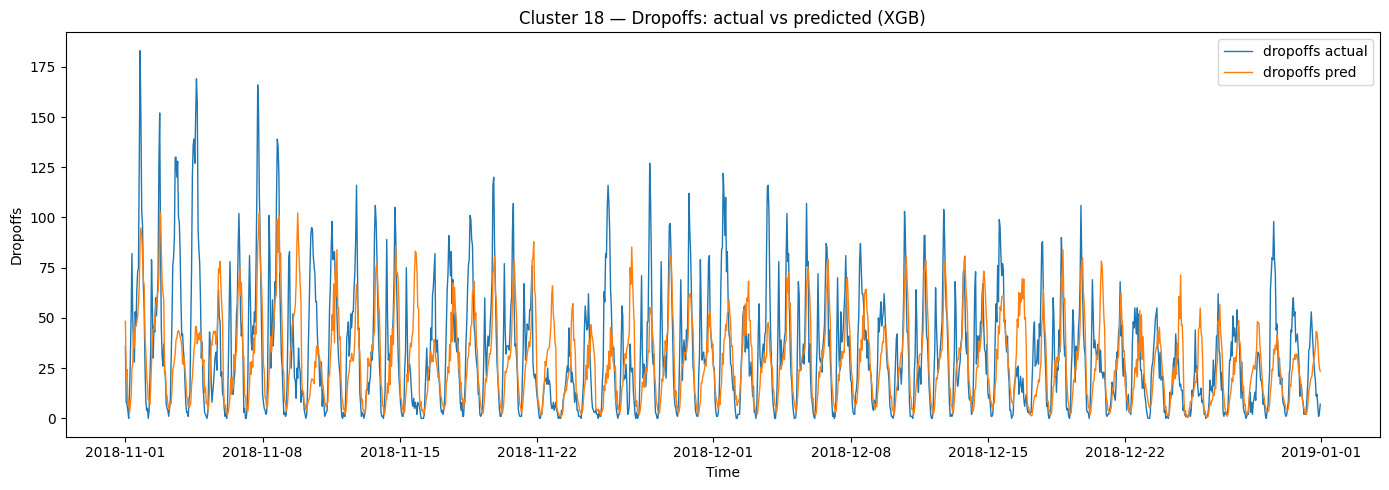

In [ ]:
# ========= 0) Imports & config =========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from typing import Dict, Tuple

# Optional XGBoost; if not installed, keep model_kind='sarima'
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ---- paths / switches ----
CSV_PATH = "/mnt/data/aggregated_demand_data.csv"   # set if you want to load from CSV
MODEL_KIND = "xgb"  # 'sarima' or 'xgb'
CLUSTERS_TO_RUN = None  # e.g. [1,2]; None -> run all clusters in data

# Train/Test windows (per project spec)
TRAIN_START = "2018-01-01 00:00:00"
TRAIN_END   = "2018-10-31 23:00:00"
TEST_START  = "2018-11-01 00:00:00"
TEST_END    = "2018-12-31 23:00:00"

# ========= 1) Load aggregated data (if not already in memory) =========
if "agg" not in globals():
    agg = pd.read_csv(CSV_PATH)

# Ensure datetime index
if not isinstance(agg.index, pd.DatetimeIndex):
    agg["datetime"] = pd.to_datetime(agg["datetime"])
    agg = agg.sort_values(["datetime", "cluster"]).set_index("datetime")

# Ensure 'demand' exists (useful for plotting/QA)
if "demand" not in agg.columns:
    agg["demand"] = agg[["pickups", "dropoffs"]].sum(axis=1)

# ========= 2) Utilities =========
def full_hour_range(df: pd.DataFrame) -> pd.DatetimeIndex:
    return pd.date_range(df.index.min().floor("H"), df.index.max().ceil("H") - pd.Timedelta(hours=0), freq="h")

def make_cluster_ts(agg: pd.DataFrame, cid: int) -> pd.DataFrame:
    """Return hourly time series for one cluster with columns ['pickups','dropoffs'] over a complete hourly index."""
    sub = agg.loc[agg["cluster"] == cid, ["pickups", "dropoffs"]]
    # aggregate to guard against duplicates
    ts = sub.groupby(sub.index)[["pickups", "dropoffs"]].sum().sort_index()
    hours = full_hour_range(ts)
    ts = ts.reindex(hours, fill_value=0)
    ts.index.name = "datetime"
    return ts

def split_train_test(ts: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train = ts.loc[TRAIN_START:TRAIN_END]
    test  = ts.loc[TEST_START:TEST_END]
    return train, test

def rmse(y_true, y_pred):
    return float(np.sqrt(((np.asarray(y_true) - np.asarray(y_pred)) ** 2).mean()))

import numpy as np
import pandas as pd

# Reproducible RNG (change seed if you want a different draw)
rng = np.random.default_rng(42)

# Unique, eligible cluster IDs (exclude noise = -1)
eligible = pd.Series(agg["cluster"].dropna().unique())
eligible = eligible[eligible != -1]

# If your clusters are floats (e.g., 1.0), make them ints for readability
try:
    eligible = eligible.astype(int)
except Exception:
    pass

# Pick 5 distinct clusters at random
if len(eligible) < 5:
    raise ValueError(f"Not enough eligible clusters to sample 5 (found {len(eligible)}).")

CLUSTERS_TO_RUN = rng.choice(eligible.to_numpy(), size=5, replace=False).tolist()
print("Selected clusters for prediction:", CLUSTERS_TO_RUN)


# ========= 3) SARIMAX fitting & daily 24-step forecast =========
def fit_sarima(y: pd.Series, seasonal_periods: int = 24):
    """
    Quick SARIMAX fit with a reasonable default order; adjust if you’ve done model selection.
    """
    # Default order: (1,1,1) with simple seasonality; you can grid-search if you want.
    mod = SARIMAX(y, order=(1,1,1), seasonal_order=(1,1,1, seasonal_periods),
                  enforce_stationarity=False, enforce_invertibility=False)
    return mod.fit(disp=False)

def forecast_next_day_sarima(ts: pd.DataFrame, day: pd.Timestamp) -> pd.DataFrame:
    """
    Given history up to the end of 'day' (23:00), forecast pickups & dropoffs for next 24 hours (day+1, 00:00..23:00).
    Returns DataFrame with index = next-day hours and columns ['pickups_pred','dropoffs_pred'].
    """
    cutoff = day.replace(hour=23, minute=0, second=0)
    hist = ts.loc[:cutoff]
    next_hours = pd.date_range(day + pd.Timedelta(days=1), periods=24, freq="h")

    preds = {}
    for tgt in ["pickups", "dropoffs"]:
        fit = fit_sarima(hist[tgt])
        fc  = fit.get_forecast(steps=24).predicted_mean
        preds[tgt] = pd.Series(np.maximum(0, fc.values), index=next_hours)

    out = pd.DataFrame({"pickups_pred": preds["pickups"], "dropoffs_pred": preds["dropoffs"]}, index=next_hours)
    return out

# ========= 4) XGBoost features & daily 24-step forecast (recursive) =========
def make_features(ts: pd.DataFrame) -> pd.DataFrame:
    d = ts.copy()
    d["hour"]  = d.index.hour
    d["dow"]   = d.index.dayofweek
    d["month"] = d.index.month
    # lags & rolling means
    for col in ["pickups", "dropoffs"]:
        d[f"{col}_lag1"]   = d[col].shift(1)
        d[f"{col}_lag24"]  = d[col].shift(24)
        d[f"{col}_lag168"] = d[col].shift(168)
        d[f"{col}_rmean24"]  = d[col].rolling(24).mean()
        d[f"{col}_rmean168"] = d[col].rolling(168).mean()
    return d

XGB_FEATURES = [
    "hour","dow","month",
    "pickups_lag1","pickups_lag24","pickups_lag168","pickups_rmean24","pickups_rmean168",
    "dropoffs_lag1","dropoffs_lag24","dropoffs_lag168","dropoffs_rmean24","dropoffs_rmean168"
]

def train_xgb_models(train_feats: pd.DataFrame) -> Dict[str, xgb.XGBRegressor]:
    models = {}
    for tgt in ["pickups", "dropoffs"]:
        y = train_feats[tgt]
        X = train_feats[XGB_FEATURES]
        model = xgb.XGBRegressor(
            objective="reg:squarederror",
            n_estimators=600,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X, y)
        models[tgt] = model
    return models

def forecast_next_day_xgb(ts: pd.DataFrame, models: Dict[str, xgb.XGBRegressor], day: pd.Timestamp) -> pd.DataFrame:
    """
    Recursive 24-step forecast for day+1 using lag/rolling features built from known history + prior predictions.
    """
    cutoff = day.replace(hour=23, minute=0, second=0)
    hist = ts.loc[:cutoff].copy()

    preds_hours = pd.date_range(day + pd.Timedelta(days=1), periods=24, freq="h")
    preds = {"pickups": [], "dropoffs": []}

    cur = hist.copy()
    for h in preds_hours:
        # build features row from current 'cur'
        feats = make_features(cur).iloc[[-1]]  # last available row after updating features
        X_row = feats[XGB_FEATURES]

        # robust scalar extraction (avoids NumPy 1.25 deprecation)
        y_pu_arr = models["pickups"].predict(X_row)
        y_do_arr = models["dropoffs"].predict(X_row)

        # Each is a length-1 array; take the scalar explicitly
        y_pu = float(np.ravel(y_pu_arr)[0])
        y_do = float(np.ravel(y_do_arr)[0])

        preds["pickups"].append(y_pu)
        preds["dropoffs"].append(y_do)

        # append this predicted hour as new "observed" to drive next step
        cur.loc[h, "pickups"]  = y_pu
        cur.loc[h, "dropoffs"] = y_do

    out = pd.DataFrame({
        "pickups_pred": preds["pickups"],
        "dropoffs_pred": preds["dropoffs"]
    }, index=preds_hours)
    return out

# ========= 5) Driver: run per cluster across test days =========
def run_forecasting_for_cluster(agg: pd.DataFrame, cid: int, model_kind: str = MODEL_KIND) -> pd.DataFrame:
    ts = make_cluster_ts(agg, cid)
    train, test = split_train_test(ts)

    # Pre-train (SARIMA re-fits each day from history; XGB trains once on Jan–Oct)
    xgb_models = None
    if model_kind == "xgb":
        if not XGB_AVAILABLE:
            raise RuntimeError("XGBoost not available; set MODEL_KIND='sarima' or install xgboost.")
        train_feats = make_features(train).dropna()
        xgb_models = train_xgb_models(train_feats)

    # loop daily across test window, do 24-step forecast from end of each previous day
    days = pd.date_range(TEST_START, TEST_END, freq="D")
    all_forecasts = []
    for d in days:
        prev_day = d - pd.Timedelta(days=1)
        if prev_day < pd.to_datetime(TRAIN_START):
            continue  # skip if not enough history

        if model_kind == "sarima":
            fc = forecast_next_day_sarima(ts, prev_day)
        else:
            fc = forecast_next_day_xgb(ts, xgb_models, prev_day)

        # attach actuals for evaluation
        actual = ts.loc[d:d + pd.Timedelta(hours=23), ["pickups", "dropoffs"]].copy()
        df = fc.join(actual, how="left")
        df["cluster"] = cid
        all_forecasts.append(df)

        # (Optional) fold actuals into ts here if you want rolling re-training per day; for SARIMA we used full history each call.

    out = pd.concat(all_forecasts).sort_index()
    return out

# ========= 6) Run for all requested clusters & evaluate =========
if CLUSTERS_TO_RUN is None:
    clusters = sorted(agg["cluster"].unique().tolist())
else:
    clusters = CLUSTERS_TO_RUN

all_preds = []
for cid in clusters:
    print(f"Forecasting cluster {cid} with {MODEL_KIND.upper()} ...")
    preds = run_forecasting_for_cluster(agg, cid, MODEL_KIND)
    all_preds.append(preds.assign(cluster=cid))

preds_all = pd.concat(all_preds).sort_index()

# ========= 7) Metrics (MAE / RMSE) =========
def compute_metrics(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for cid, g in df.groupby("cluster"):
        for tgt in ["pickups", "dropoffs"]:
            y_true = g[tgt].values
            y_pred = g[f"{tgt}_pred"].values
            rows.append({
                "cluster": cid,
                "target": tgt,
                "MAE": mean_absolute_error(y_true, y_pred),
                "RMSE": rmse(y_true, y_pred),
                "N": len(y_true)
            })
    return pd.DataFrame(rows).sort_values(["target","cluster"])

metrics = compute_metrics(preds_all)
display(metrics)

# ========= 8) Quick visual check for one cluster =========
example_cid = clusters[0]
g = preds_all.loc[preds_all["cluster"] == example_cid]
plt.figure(figsize=(14,5))
plt.plot(g.index, g["pickups"], label="pickups actual", linewidth=1)
plt.plot(g.index, g["pickups_pred"], label="pickups pred", linewidth=1)
plt.title(f"Cluster {example_cid} — Pickups: actual vs predicted ({MODEL_KIND.upper()})")
plt.xlabel("Time"); plt.ylabel("Pickups"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(14,5))
plt.plot(g.index, g["dropoffs"], label="dropoffs actual", linewidth=1)
plt.plot(g.index, g["dropoffs_pred"], label="dropoffs pred", linewidth=1)
plt.title(f"Cluster {example_cid} — Dropoffs: actual vs predicted ({MODEL_KIND.upper()})")
plt.xlabel("Time"); plt.ylabel("Dropoffs"); plt.legend(); plt.tight_layout(); plt.show()


arima, gradientboostingregressor, linearregressor, mlpregressor

2. You are expected to build a prediction model that, at the end of a day, allows to 
predict what the demand for a cluster of stations will be over the next 24 hours – i.e. 
not the total demand for the next day, but how the time-series of the demand will look 
like for the next day (e.g., given demand data until midnight of day 1, predict the 
number of pickups for all 1h intervals (12-1am, 1-2am, 6-7am, 7-8am, …, 11-12pm) 
in day 2). You should predict both the arrivals (i.e., bicycle dropoffs) and the 
departures (pickups). You should use a time aggregation of one hour or less. You 
can choose to use two different models or a single one to predict both. It is up to you 
to determine the most effective way to formulate this problem as a machine learning 
problem. You should not shuffle the data. You should instead use the data from 
January to October (included) to train your model, and the data from November and 
December as a test set. You can use any model you want.

januar - oktober -> train
november - december -> test

Overnight, the bike-sharing company manually repositions its bikes to ensure that 
demand for the next day can be met. You are expected to use the outputs from the 
prediction model above to compute the required number of bicycles to be placed in 
each cluster of stations analyzed in Task 2 at the beginning of the next day. To 
compute this number, you can use the cumulative of the arrivals and departures. The 
goal is to ensure that, over the duration of the next day, there will never be a shortage 
of bikes – or, if there is, the goal is to minimize the number of bikes in deficit. The 
number of bicycles required can be estimated by extrapolating the maximum 
difference between the number of departures and arrivals. 